In [1]:
import numpy as np

class KalmanFilter3D:
    def __init__(self, percent_var=0.05, gain=0.8):
        self.percent_var = percent_var
        self.gain = gain

    def filter(self, stack):
        """
        Applies the Kalman Filter to a 3D grayscale image stack.

        Args:
            stack (np.ndarray): The input image stack, shape (stack_size, height, width).

        Returns:
            np.ndarray: The filtered image stack, shape (stack_size, height, width).
        """

        stack_size, height, width = stack.shape
        dimension = height * width

        predicted = stack[0].flatten()
        predicted_var = np.ones(dimension) * self.percent_var
        observed = np.empty_like(predicted)
        kalman_gain = np.empty_like(predicted)
        corrected = np.empty_like(predicted)
        corrected_var = np.empty_like(predicted)

        for i in range(1, stack_size):
            observed[:] = stack[i].flatten()

            kalman_gain[:] = predicted_var / (predicted_var + self.percent_var)
            corrected[:] = self.gain * predicted + (1.0 - self.gain) * observed + \
                kalman_gain * (observed - predicted)
            corrected_var[:] = predicted_var * (1.0 - kalman_gain)

            predicted = corrected
            predicted_var = corrected_var

            stack[i] = corrected.reshape(height, width)

        return stack

In [2]:
import tifffile

def read_tif_stack(filename):
    """Reads a .tif image stack into a 3D NumPy array.

    Args:
        filename: The path to the .tif file.

    Returns:
        A 3D NumPy array containing the image stack.
    """

    with tifffile.TiffFile(filename) as tif:
        return tif.asarray()

In [3]:
import os
import numpy as np

root = "C:\\Users\\svw191\\PythonFiles\\PythonTrial\\LED +APs 240926\\240926_pl100_pc001_LED+APs500microW_ex01\\DATA\\ChanB"
filename = "ChanB_stk.tif"
# stack = read_tif_stack(os.path.join(root,filename))

tif_stk = read_tif_stack(os.path.join(root, filename))
print(np.shape(tif_stk))

(2950, 512, 512)


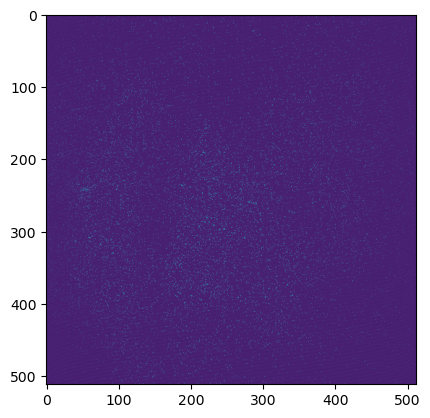

In [4]:
import matplotlib.pyplot as plt

plt.imshow(tif_stk[1000,:,:])

In [5]:
import time

# Example usage:
# Assuming you have a 3D grayscale image stack loaded into a NumPy array 'stack'

raw_tif_stk = np.copy(tif_stk) # saves for comparison

start_time = time.time()

filtered_stack = KalmanFilter3D().filter(tif_stk)

end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 21.94055414199829 seconds


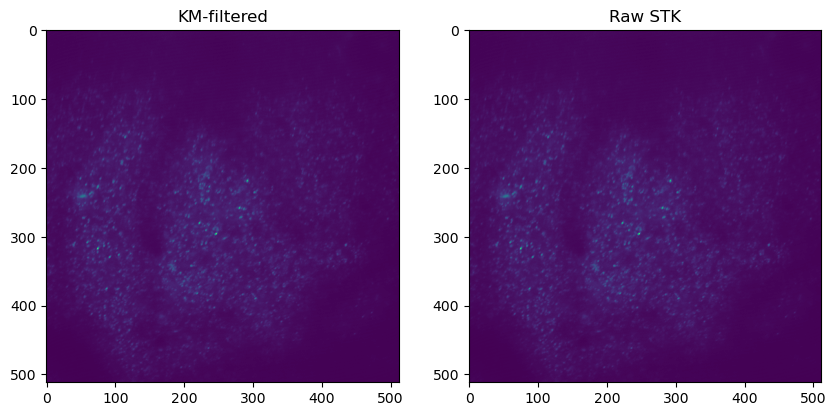

In [7]:
# check out the array
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Display the first array in the first subplot
axes[0].imshow(np.mean(filtered_stack, axis=0))
axes[0].set_title('KM-filtered')

# Display the second array in the second subplot
axes[1].imshow(np.mean(raw_tif_stk, axis=0))
axes[1].set_title('Raw STK')

plt.show()


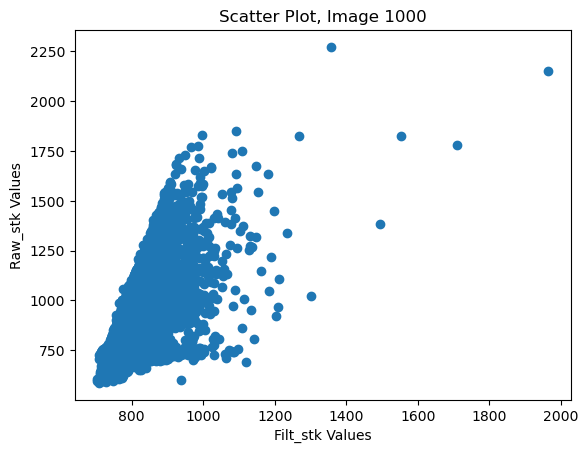

In [12]:
plt.scatter(filtered_stack[1000,:,:],raw_tif_stk[1000,:,:])
plt.xlabel('Filt_stk Values')
plt.ylabel('Raw_stk Values')
plt.title('Scatter Plot, Image 1000')
plt.show()

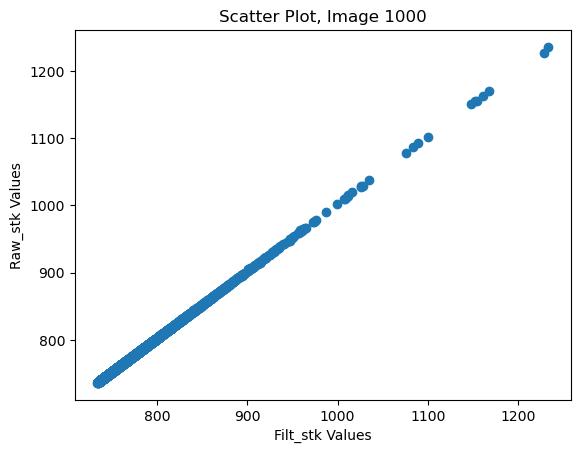

In [15]:
plt.scatter(np.mean(filtered_stack[1000:2010,:,:], axis=0),np.mean(raw_tif_stk[1000:2010,:,:], axis=0))
plt.xlabel('Filt_stk Values')
plt.ylabel('Raw_stk Values')
plt.title('Scatter Plot, Image 1000')
plt.show()

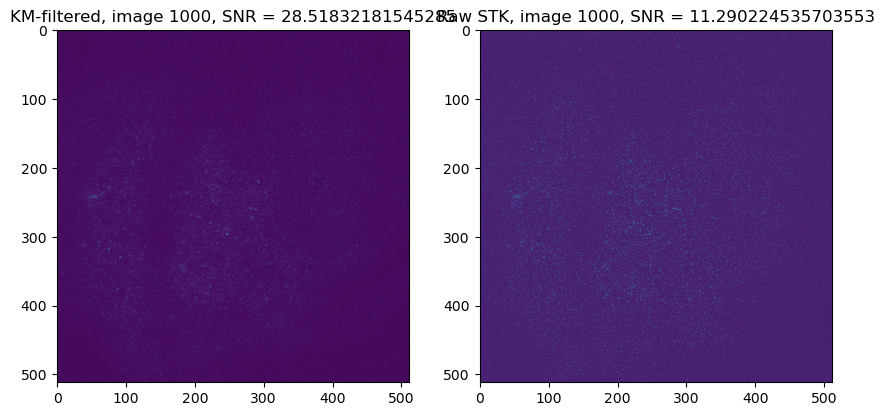

In [6]:
# check out the array
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

SNR_filt_1000 = np.mean(filtered_stack[1000,:,:])/np.std(filtered_stack[1000,:,:])

# Display the first array in the first subplot
ax2[0].imshow(filtered_stack[1000,:,:])
ax2[0].set_title(f'KM-filtered, image 1000, SNR = {SNR_filt_1000}')

SNR_raw_1000 = np.mean(raw_tif_stk[1000,:,:])/np.std(raw_tif_stk[1000,:,:])

# Display the second array in the second subplot
ax2[1].imshow(raw_tif_stk[1000,:,:])
ax2[1].set_title(f'Raw STK, image 1000, SNR = {SNR_raw_1000}')

plt.show()


In [17]:
# calculate SNR form Fourier Space
import numpy as np
import scipy.fftpack as fft
import cv2

def calculate_snr_frequency_domain(image):
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Perform Fourier Transform
    f_image = fft.fft2(gray_image)

    # Shift zero-frequency component to center
    f_shifted = fft.fftshift(f_image)

    # Calculate power spectrum
    power_spectrum = np.abs(f_shifted)**2

    # Define a threshold to separate signal and noise (adjust as needed)
    threshold = np.mean(power_spectrum)

    # Create masks for signal and noise regions
    signal_mask = power_spectrum > threshold
    noise_mask = power_spectrum <= threshold

    # Calculate power of signal and noise
    power_signal = np.sum(power_spectrum[signal_mask])
    power_noise = np.sum(power_spectrum[noise_mask])

    # Calculate SNR
    snr = power_signal / power_noise

    return snr

In [18]:
# Fourier form SNRs

SNR_FT_raw1000 = calculate_snr_frequency_domain(raw_tif_stk[1000,:,:])
print(f'SNR_FT_raw1000 = {SNR_FT_raw1000}')

SNR_FT_raw_tot = calculate_snr_frequency_domain(raw_tif_stk[:,:,:])
print(f'SNR_FT_raw_tot = {SNR_FT_raw_tot}')

SNR_FT_filt1000 = calculate_snr_frequency_domain(filtered_stack[1000,:,:])
print(f'SNR_FT_filt1000 = {SNR_FT_filt1000}')

SNR_FT_filt_tot = calculate_snr_frequency_domain(filtered_stack[:,:,:])
print(f'SNR_FT_filt_tot = {SNR_FT_filt_tot}')

SNR_FT_avg = calculate_snr_frequency_domain(np.mean(raw_tif_stk, axis=0))
print(f'SNR_FT_avg = {SNR_FT_avg}')

SNR_FT_raw1000 = 129.93564549827752


error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 512


In [15]:
# Basic SNRs

SNR_raw1000 = np.mean(raw_tif_stk[1000,:,:])/np.std(raw_tif_stk[1000,:,:])
print(f'SNR_raw1000 = {SNR_raw1000}')

SNR_raw_tot = np.mean(raw_tif_stk[:,:,:])/np.std(raw_tif_stk[:,:,:])
print(f'SNR_raw_tot = {SNR_raw_tot}')

SNR_filt1000 = np.mean(filtered_stack[1000,:,:])/np.std(filtered_stack[1000,:,:])
print(f'SNR_filt1000 = {SNR_filt1000}')

SNR_filt_tot = np.mean(filtered_stack[:,:,:])/np.std(filtered_stack[:,:,:])
print(f'SNR_filt_tot = {SNR_filt_tot}')

SNR_avg = np.mean(np.mean(raw_tif_stk, axis=0))/np.std(np.mean(raw_tif_stk, axis=0))
print(f'SNR_avg = {SNR_avg}')


SNR_raw1000 = 11.290224535703553
SNR_raw_tot = 10.830124937355556
SNR_filt1000 = 28.51832181545285
SNR_filt_tot = 27.806816090000822
SNR_avg = 58.77796691302266
